# Installing and importing packages

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.example_libraries import optimizers
from matplotlib import pyplot as plt
from jax.scipy.special import erf
import jax.random as random
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import jax
import numpy as np
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

from IPython import display

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


# Domaine adaptation for 2D points cloud

In this section, we create 2 sets of points clouds : 
* in the first set (source set) there is `n1` points labeled 1 and `n2` labeled -1, **the labels are known** during training.
* in the second set (target set) there is `n1_` points labeled 1 and `n2_` labeled -1, **the labels are not known** during training.

The main idea is to create a classifier (here an SVM) for the first set and using optimal transport, to adapt it for the second dataset.

## Datasets generation and first classifier

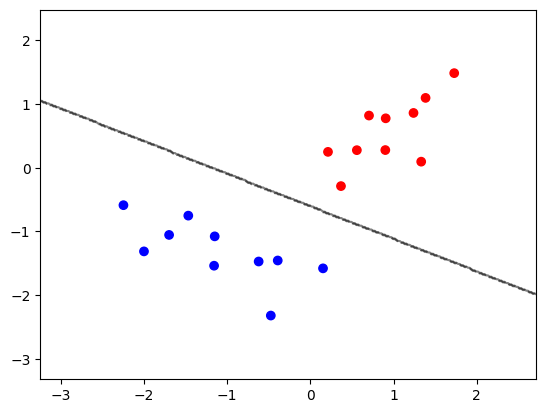

In [2]:
# Generate random points following the Gaussian distributions for the source
mean1 = jnp.array([1, 1])
cov1 = jnp.array([[0.2, 0.1], [0.1, 0.3]])
mean2 = jnp.array([-1, -1])
cov2 = jnp.array([[0.5, -0.4], [-0.2, 0.4]])
n1 = 10
n2 =10

def Generate2DDataset(mean1, cov1, mean2, cov2,n1 = 10,  n2 = 10, randomkey =1):
  """
    Generate random a set of random points following the Gaussian distribution : 
    `n1` points wil be labeled 1 and be distributed w.r.t. a Gaussian law (`mean1`, `cov1`)
    `n2` points wil be labeled -1 and be distributed w.r.t. a Gaussian law (`mean2`, `cov2`)
    """
  key = random.PRNGKey(randomkey)
  x1 = random.multivariate_normal(key, mean1, cov1, (n1,))
  x2 = random.multivariate_normal(key, mean2, cov2, (n2,))
  X = jnp.concatenate([x1, x2])
  y = jnp.concatenate([jnp.ones((n1,)), -jnp.ones((n2,))])
  return x1,x2,X,y

x1,x2,X,y = Generate2DDataset(mean1, cov1, mean2, cov2,n1, n2)


def makeSVM(X,y, kernel = 'linear') :
  "Create a SVM classifier with kernel `kernel` from a dataset of features `X` and labels `y`"
  svm = SVC(kernel=kernel)
  svm.fit(X, y)
  return svm

svm = makeSVM(X,y)

# Plot the data and the decision boundary
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.show()

In [3]:
# Generate random points following the Gaussian distributions for target 
mean1 = jnp.array([3, 1])
cov1 = jnp.array([[0.4, 0.1], [0.3, 0.5]])
mean2 = jnp.array([3, -2])
cov2 = jnp.array([[0.3, -0.4], [-0.2, 0.4]])
n1_=10
n2_=10
x1_,x2_,X_,y_ = Generate2DDataset(mean1, cov1, mean2, cov2, n1_, n2_, randomkey =2)

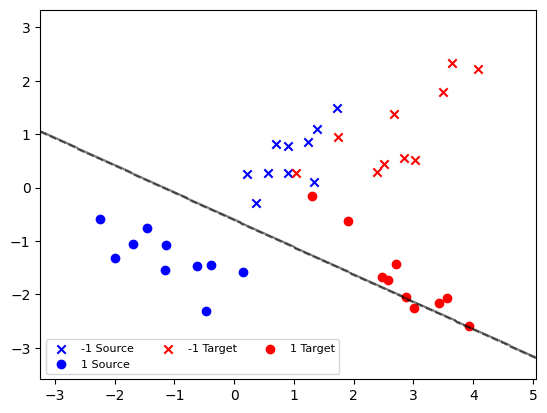

In [4]:
# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

The reuslting classifier is not all adapted for the target datset

## Optimal Transport from source to target dataset

In [5]:
# Plotting the transportation plan
def plot_map(x, y, z, forward: bool = True):
    plt.figure(figsize=(10, 8))
    marker_t = "o" if forward else "X"
    label = (
        r"$T_{x\rightarrow y}(x)$" if forward else r"$T_{y\rightarrow x}(y)$"
    )
    w = x if forward else y
    plt.quiver(
        *w.T,
        *(z - w).T,
        color="k",
        angles="xy",
        scale_units="xy",
        scale=1,
        width=0.007,
    )
    plt.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
    plt.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
    plt.scatter(*z.T, s=150, edgecolors="k", marker=marker_t, label=label)
    plt.legend(fontsize=22)

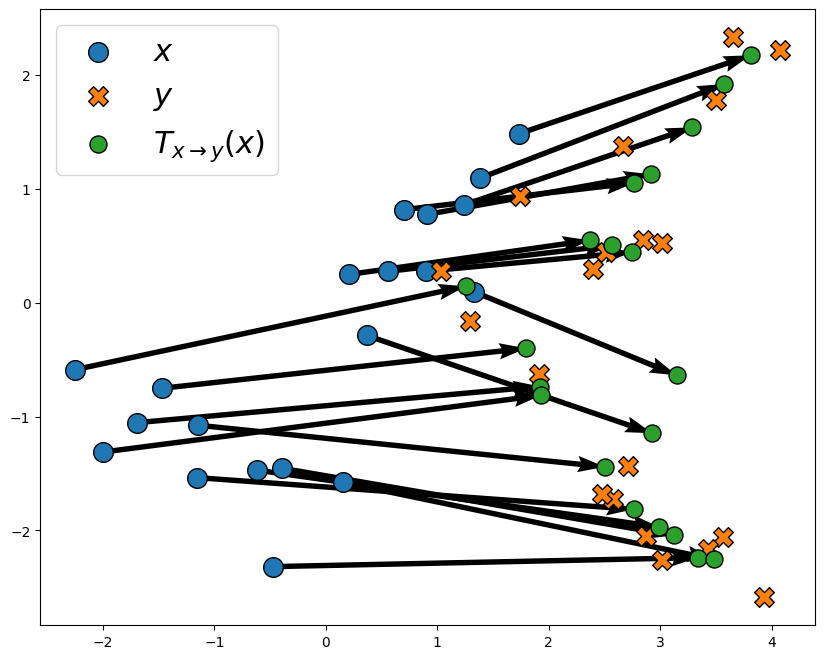

In [6]:
def getTransport(X, X_, cost_fn = costs.SqEuclidean(), plot = True):
  """ Get the transported points from a source set `X` to a target set `X_, where the cost function is defined by `cost_fn`. `plot` = `True` plot the transportation plan if possible. """
  geom = pointcloud.PointCloud(X, X_, cost_fn=cost_fn) #  cost_fn permet de changer la fonction coût ici
  out = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom))
  dual_potentials = out.to_dual_potentials()
  if plot == True and len(X[0])==2 and len(X_[0]) == 2:
    plot_map(X, X_, dual_potentials.transport(X))
   
  return dual_potentials.transport(X)

tX = getTransport(X,X_)

We now train the classifier on the transported points `tX` using the source labeled `y`

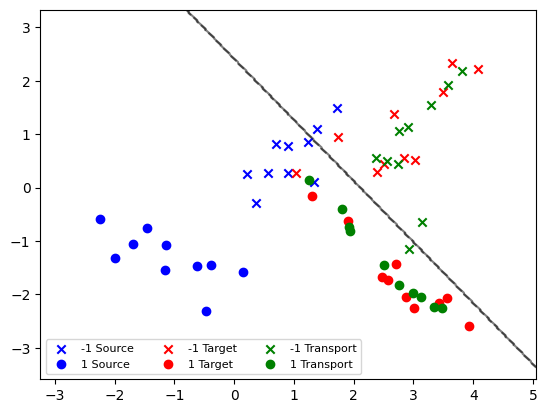

In [7]:
svm = makeSVM(tX,y)

# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
p5 = plt.scatter(tX[:,0][:n1], tX[:,1][:n1], marker='x', color=colors[2])
p6 = plt.scatter(tX[:,0][n1:], tX[:,1][n1:], marker='o', color=colors[2])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4, p5, p6),
           ('-1 Source', '1 Source', '-1 Target', '1 Target', '-1 Transport', '1 Transport'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

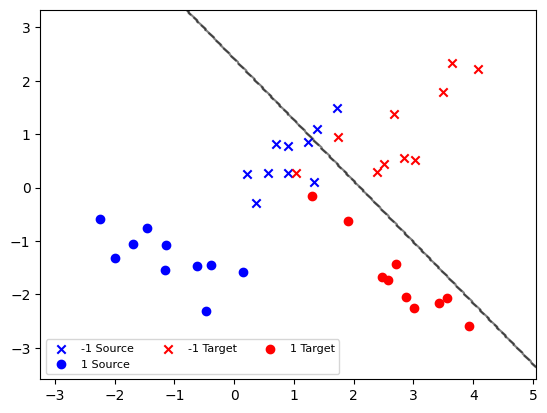

In [8]:
# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

This new classifier is way more adapted for the target dataset.

## Trying to get best of both worlds

Each of the classifer is well adapted for the source or the target dataset only. Since the source and target dataset "live" on the same space (here $\mathbb{R}^2$), we're looking for a classifier that seperate fairly all the points (from both the source and the target datasets) laeled -1 and 1

### First idea : mid transported points

We simply take the middle of the if the transportation plan and build the classifier on those points.

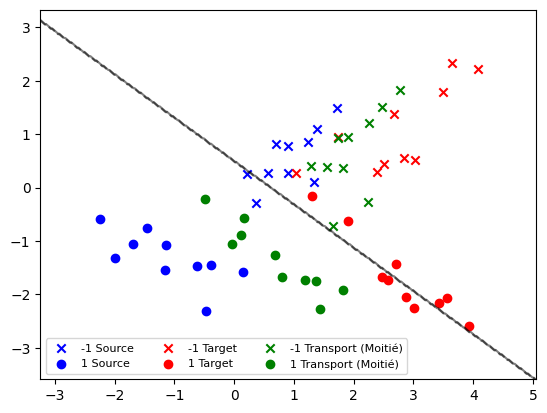

In [9]:
# We plot the boundary decision made for the middle of the transportation plan :
meanX = (tX+X)/2
svm = makeSVM(meanX,y)

# Plot the data and the decision boundary
colors = ['b', 'r', 'g']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])
p5 = plt.scatter(meanX[:,0][:n1], meanX[:,1][:n1], marker='x', color=colors[2])
p6 = plt.scatter(meanX[:,0][n1:], meanX[:,1][n1:], marker='o', color=colors[2])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = svm.predict(jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4, p5, p6),
           ('-1 Source', '1 Source', '-1 Target', '1 Target', '-1 Transport (Moitié)', '1 Transport (Moitié)'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

## Second idea : Voting Classifier

We cut out the transport plan into`step` steps, build a classifier for each intermediary step (including the first classifier on the source dataset) and build a voting classifier that be train either on all the intermediary step of the transportation plan or only on the source and final transported points. 

In [10]:
from sklearn.ensemble import VotingClassifier
step = 10

def votingclassifier(X,y, tX,step = 10, longtrain = True):
  """ Build a Voting classifer. The intermediary classifier are trained on each step of the transportation plan
   from the source dataset `X` to the transported dataset `tX` with label `y`, that has been cut out in `step`steps.
   The argument `longtrain` = `True`, `False`or `'both'` defines how the resulting voting classifier(s) is (are) trained : 
   * `True` : on all intermediary dataset
   * `False` :  only on original and transported  dataset
   * `both` : the two previous classifiers are returned"""
  svm0 = makeSVM(X,y)
  X_t = X
  y_t = y
  if longtrain ==False or longtrain =='both':
    X_t2 = jnp.concatenate([X, tX])
    y_t2 = jnp.concatenate([y, y])
  svm = [svm0]
  for i in range(1, step+1):
    newX = ((step-i)/step)*X + (i/step)*tX
    X_t = jnp.concatenate([X_t, newX])
    y_t = jnp.concatenate([y_t, y])
    svm.append(makeSVM(newX,y))

  estimator = []
  for i in range(len(svm)):
    estimator.append((str(i), svm[i]))
  # Create voting ensemble of SVM linear classifiers
  ensemble = VotingClassifier(estimators=estimator, voting='hard')

  # Fit the ensemble on the training data
  if longtrain == False :
    ensemble.fit(X_t2, y_t2)
    return ensemble
  elif longtrain == 'both':
    return ensemble.fit(X_t,y_t), ensemble.fit(X_t2,y_t2)
  else : 
    return ensemble.fit(X_t,y_t)

ensemble1, ensemble2 = votingclassifier(X,y,tX, step, longtrain = 'both')

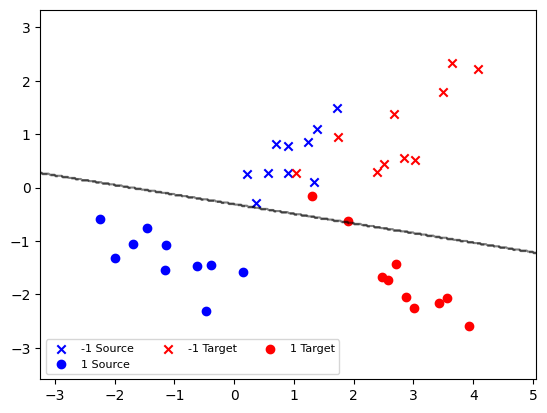

In [11]:
# Plot with the training on all the intermediary steps of the transport plan

svmcolors = ['b', 'r']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])


x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = ensemble1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

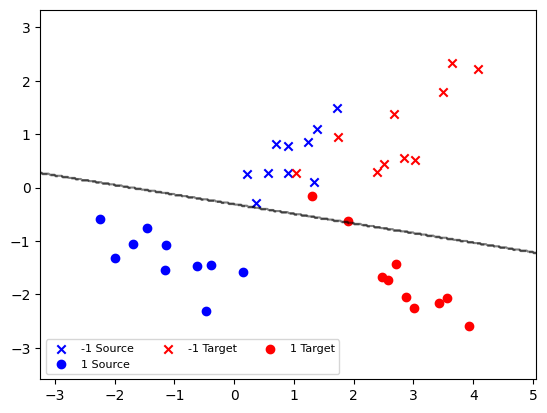

In [12]:
# Plot with the training on the orignal and the transported points

svmcolors = ['b', 'r']
p1 = plt.scatter(X[:,0][:n1], X[:,1][:n1], marker='x', color=colors[0])
p2 = plt.scatter(X[:,0][n1:], X[:,1][n1:], marker='o', color=colors[0])
p3 = plt.scatter(X_[:,0][:n1_], X_[:,1][:n1_], marker='x', color=colors[1])
p4 = plt.scatter(X_[:,0][n1_:], X_[:,1][n1_:], marker='o', color=colors[1])

x_min, x_max = min(X[:, 0].min(),X_[:, 0].min()) - 1, max(X[:, 0].max(), X_[:, 0].max()) + 1
y_min, y_max = min(X[:, 1].min(),X_[:, 1].min()) - 1, max(X[:, 1].max(), X_[:, 1].max()) + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, 0.02), jnp.arange(y_min, y_max, 0.02))
Z = ensemble2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

plt.legend((p1, p2, p3, p4),
           ('-1 Source', '1 Source', '-1 Target', '1 Target'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

The difference is minimal because the dataset are sufficiently separated.

# Caltech Office Dataset

The dataset contains images coming from four different domains: Amazon (online merchant), the Caltech-256 image collection, Webcam (images taken from a webcam) and DSLR (images taken from a high resolution digital SLR camera). The variability of the different domains come from several factors: presence/absence of background, lightning conditions, noise, etc. We consider the features set DeCaf: these features are extracted as the sparse activation of
the neurons from the fully connected 6th and 7th layers of a convolutional network trained on imageNet and then fine tuned on the visual recognition tasks considered here. As such, they form vectors with 4096 dimensions.

## Get the dataset

In [13]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile


def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)
download_and_unzip('https://github.com/mdlbm/Optimal-Transport-Domain-Adaptation/raw/main/data/decaf6.zip')


In [14]:
import os, sys, traceback
import matplotlib.pylab as pylab
import numpy as np
import pylab as pl
from scipy.io import loadmat
from scipy.stats.mstats import zscore
# Four domains: { Caltech10, amazon, webcam, dslr }
possible_DTS = ['caltech', 'amazon', 'webcam', 'dslr']

tests = []
data = {}

for ds in possible_DTS:
    if "google.colab" in sys.modules:
      path = '/content/'+ds+'_decaf.mat'
    else :
      path = ds+'_decaf.mat'
    possible_data = loadmat(path)
    feat = possible_data['feas'].astype(float)
    labels = possible_data['labels']
    data[ds]=[feat,labels]


##Create a simple MLP for one of the dataset

In [15]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['caltech'][0], data['caltech'][1], test_size=0.1, random_state=42)

# Define the neural network model
model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, alpha=0.01,
                      solver='sgd', verbose=False, random_state=42,
                      learning_rate_init=0.1)
# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.3274336283185841


## Create classifiers by using transportation plans

## Using MLP

In [16]:
#Get model without transport 
def DataTest(dataset1, hidden_sizes = (50,)):
    # Define the neural network model
  model = MLPClassifier(hidden_layer_sizes=hidden_sizes, max_iter=500, alpha=0.01,
                        solver='sgd', verbose=False, random_state=42,
                        learning_rate_init=0.1)

  # Train the model
  model.fit(data[dataset1][0], data[dataset1][1])
  return model

def GetAccuracy(model, dataset2):
  accuracy = model.score(data[dataset2][0], data[dataset2][1])
  return accuracy


# Transport one dataset to another :

def DataTransport(dataset1, dataset2, hidden_sizes = (50,)):
  trX = getTransport(data[dataset1][0], data[dataset2][0])
  # Define the neural network model
  model = MLPClassifier(hidden_layer_sizes=hidden_sizes, max_iter=500, alpha=0.01,
                        solver='sgd', verbose=False, random_state=42,
                        learning_rate_init=0.1)

  # Train the model
  model.fit(trX, data[dataset1][1])

  # Evaluate the model on the test set
  accuracy = model.score(data[dataset2][0], data[dataset2][1])
  # print("Accuracy:", accuracy)
  return accuracy

In [17]:
without_ott = {'caltech':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'amazon':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'webcam':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'dslr':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0}}
with_ott= {'caltech':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'amazon':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'webcam':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'dslr':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0}}
for i in possible_DTS:
  model = DataTest(i, hidden_sizes = (50,))
  for j in possible_DTS:
    without_ott[i][j] = GetAccuracy(model,j)
    if i != j: 
      # print('Accuracy result from {} to {} :'.format(i,j))
      with_ott[i][j] = DataTransport(i,j, hidden_sizes=(50,))
    else :
      with_ott[i][j] = GetAccuracy(model,j)

      


      

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed w

In [18]:
import pandas as pd
without_ =pd.DataFrame.from_dict(without_ott,orient='index')
# without_.to_csv('/content/without50.csv')
without_

,caltech,amazon,webcam,dslr
caltech,0.376670,0.338205,0.257627,0.292994
amazon,0.199466,0.189979,0.132203,0.197452
webcam,0.089047,0.098121,0.122034,0.076433
dslr,0.157614,0.178497,0.172881,0.280255


In [19]:
with_ =pd.DataFrame.from_dict(with_ott,orient='index')
# with_.to_csv('/content/with50.csv')
with_

,caltech,amazon,webcam,dslr
caltech,0.376670,0.270355,0.118644,0.070064
amazon,0.377560,0.189979,0.203390,0.216561
webcam,0.115761,0.081420,0.122034,0.356688
dslr,0.266251,0.118998,0.406780,0.280255


The lines designates the original dataset, the rows the target ones.

## Using RandomForest

In [20]:
#Get model without transport 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
def DataTestRF(dataset1, n_estimators = 5, max_depth=2, random_state=42):
  classifier = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(RandomForestClassifier(n_estimators = n_estimators, max_depth= max_depth, random_state=random_state)))

  # Train the model
  classifier.fit(data[dataset1][0], data[dataset1][1])
  return classifier


# Transport one dataset to another :

def DataTransportRF(dataset1, dataset2, n_estimators = 5, max_depth=2, random_state=42):
  trX = getTransport(data[dataset1][0], data[dataset2][0])
  # Define the neural network model
  classifier = make_pipeline(
    StandardScaler(),
    OneVsRestClassifier(RandomForestClassifier(n_estimators = n_estimators, max_depth= max_depth, random_state=random_state)))

  # Train the model
  classifier.fit(trX, data[dataset1][1])

  # Evaluate the classifier on the test set
  accuracy = classifier.score(data[dataset2][0], data[dataset2][1])
  # print("Accuracy:", accuracy)
  return accuracy

In [21]:
without_ott = {'caltech':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'amazon':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'webcam':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'dslr':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0}}
with_ott= {'caltech':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'amazon':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'webcam':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0},
               'dslr':{'caltech': 0, 'amazon' : 0, 'webcam': 0, 'dslr' : 0}}
for i in possible_DTS:
  model = DataTestRF(i)
  for j in possible_DTS:
    without_ott[i][j] = GetAccuracy(model,j)
    if i != j: 
      # print('Accuracy result from {} to {} :'.format(i,j))
      with_ott[i][j] = DataTransportRF(i,j)
    else :
      with_ott[i][j] = GetAccuracy(model,j)

In [22]:
without_ =pd.DataFrame.from_dict(without_ott,orient='index')
# without_.to_csv('/content/without.csv')
without_

,caltech,amazon,webcam,dslr
caltech,0.792520,0.727557,0.505085,0.611465
amazon,0.648264,0.894572,0.437288,0.592357
webcam,0.398931,0.493737,0.925424,0.828025
dslr,0.423865,0.482255,0.667797,0.949045


In [23]:
with_ =pd.DataFrame.from_dict(with_ott,orient='index')
# with_.to_csv('/content/with.csv')
with_

,caltech,amazon,webcam,dslr
caltech,0.792520,0.724426,0.566102,0.802548
amazon,0.567231,0.894572,0.613559,0.662420
webcam,0.422084,0.565762,0.925424,0.643312
dslr,0.487979,0.601253,0.220339,0.949045


It is more efficient for tagging bigger dataset from smaller labeled ones.

NB : since the different features dataset "lives" on the same space (output of the sparse activation of a neural network) we could make the Voting Classifier). 



## PCA on the dataset

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def datasets_compare(possible_DTS= possible_DTS):
    df = pd.DataFrame()
    for i in possible_DTS:
      df1 = pd.DataFrame(data[i][0])
      df1.index=f"{i}."+df1.index.astype('str')
      df1.to_csv('/content/{}.tsv'.format(i), sep = '\t') 
      df = pd.concat([df,df1])

    # df['class'] = df.index
    # df.to_csv('/content/all.tsv'.format(i), sep = '\t')


    df_l = pd.DataFrame()
    for i in possible_DTS:
      df1_l = pd.DataFrame(data[i][1])
      df1_l.index=f"{i}."+df1_l.index.astype('str')
      df1_l.to_csv('/content/{}.tsv'.format(i), sep = '\t') 
      df_l = pd.concat([df_l,df1_l])

    return df, df_l

def get_PCA_datasets(df) : 
    colors = ['red' if i.startswith('caltech') else
          'blue' if i.startswith('amazon') else
          'green' if i.startswith('webcam') else
          'purple' for i in df.index]

    # Instantiate PCA object with 3 components
    pca = PCA(n_components=3)

    # Fit the model with data
    pca.fit(df)

    # Transform the data
    X_pca = pca.transform(df)

    # Plot the results in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c = colors)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()

def get_PCA_label(df,df_l):

    # df_normalized=(df - df.mean()) / df.std()

    label_color_map = {1 : 'red',
                   2 : 'blue',
                   3 : 'green',
                   4 : 'purple',
                   5 : 'orange',
                   6 : 'brown',
                   7 : 'gray',
                   8 : 'pink',
                   9 : 'black',
                   10 : 'yellow'}
    colors = [label_color_map[label] for label in df_l[0]]
    # Instantiate PCA object with 3 components
    pca = PCA(n_components=3)

    # Fit the model with data
    pca.fit(df)

    # Transform the data
    X_pca = pca.transform(df)

    # Plot the results in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c = colors)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()


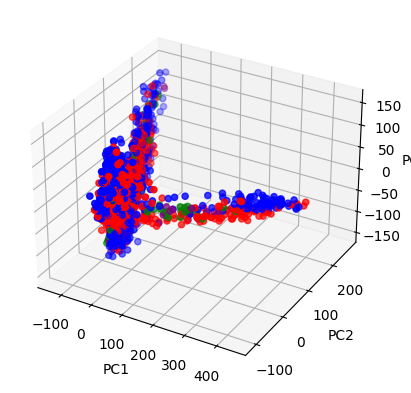

In [25]:
df, df_l = datasets_compare()
get_PCA_datasets(df)

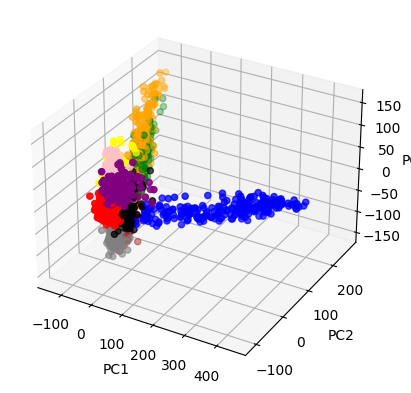

In [26]:
get_PCA_label(df,df_l)

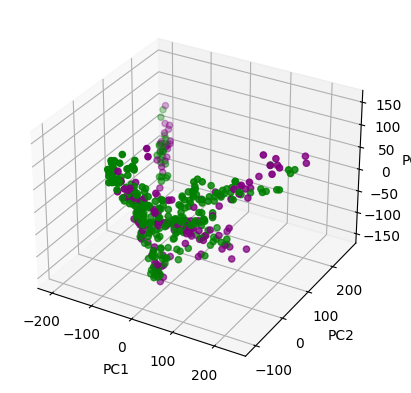

In [27]:
df1, df1_l = datasets_compare(['dslr','webcam'])
get_PCA_datasets(df1)

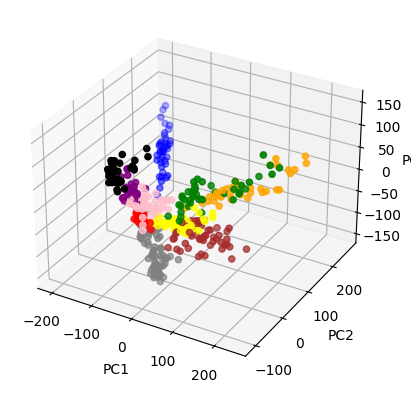

In [28]:
get_PCA_label(df1,df1_l)

In [29]:
for i in possible_DTS:
  print('Length of {} : {}'.format(i, len(data[i][0])))

Length of caltech : 1123
Length of amazon : 958
Length of webcam : 295
Length of dslr : 157
